<h1 align=center><font size = 5>Big Data NLP with Reddit r/Politics</font></h1>

<h3 align=center>Chris Lowe, Steve Ronkowski, Roy Roongseang, Jonathan Williams</h3>

## Introduction

Reddit the third largest social media platforms on the internet. It allows users to post articles and comments to a specific topic or subreddit as it is called on the platform. Due to Reddit's size and influence it was recently targeted by state sponsored misinformation campaigns. After the 2016 presidential election Reddit published a transparency report detailing suspected acivity to exploit the platform by Russia's Internet Research Agency, and banned 944 accounts linked with the agency. In 2019, 66 more accounts were identified and banned as being linked to Russian activity.

Business Problem:  This project focuses on comments posted to r/politics, which is one of the highest traffic subreddits with an average of 1-2 million comments per month. The aim is to use machine learning techniques to assist the 10 person volunteer moderation team with identifying suspicous comments for further human review.

## Table of Contents

1. [Data Cleaning](#0)<br>
2. [Data Preprocessing](#1)<br>
3. [Visualizing Data](#2)<br>
3. [Modeling](#3)<br>


Data Sources:
1. Bigquery public dataset of Reddit comments from Jan 2015 to Sept 2019.
2. Suspicious accounts banned by Reddit were extracted these reports.
[2017 Transparency Report](https://www.reddit.com/r/announcements/comments/8bb85p/reddits_2017_transparency_report_and_suspect/), 
[2019 Announcement](https://www.reddit.com/r/redditsecurity/comments/e74nml/suspected_campaign_from_russia_on_reddit/)
3. Pushshift prescraped data of Reddit user information - updated Sept 2018.
4. Reddit API pulled user data of banned accounts not included in Pushshift data. (see Reddit_User_API_Scraper.ipynb)

In [1]:
spark

In [2]:
#import statements
from pyspark.sql import SparkSession,SQLContext
import pandas as pd
from pyspark.sql.functions import *
from datetime import datetime
from pyspark.sql.types import IntegerType, StructType, StructField, StringType
import time

In [57]:
spark = SparkSession.builder.appName('Final_project').getOrCreate()
#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '10g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '6'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

sc = spark.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

In [5]:
#Datapath
path_comments = "/user/rroongseang/bigdata/parquet1516/"
path_users = "/user/rroongseang/bigdata/users/"

In [6]:
#Read data
df = sqlContext.read.parquet(path_comments)
users = spark.read.csv(path_users+"RA.2019-09.csv", inferSchema=True, header=True)
botusers = sqlContext.read.csv(path_users+'bot_userdata.csv',header=True)

# Data Cleaning <a id="0"></a>

Data cleaning steps:
    1. Drop unused columns
    2. Convert data types from string to integer or timestamp
    3. Fill in missing values
    4. Join comments dataframe with user dataframe

In [7]:
df.count()

23713927

In [8]:
#Count of null values by columns
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+--------+------+----------------------+-----------------+----+----------------+-----------+-------------+--------+------+---+-------+--------+---------+------------+-----+------------+---------+------------+-------+
|archived|author|author_flair_css_class|author_flair_text|body|controversiality|created_utc|distinguished|   downs|gilded| id|link_id|    name|parent_id|retrieved_on|score|score_hidden|subreddit|subreddit_id|    ups|
+--------+------+----------------------+-----------------+----+----------------+-----------+-------------+--------+------+---+-------+--------+---------+------------+-----+------------+---------+------------+-------+
|21549151|     0|              23066121|         23066526|   0|               0|          0|     23341202|21549151|     0|  0|      0|21549151|        0|       18219|    0|    21549151|        0|           0|6700995|
+--------+------+----------------------+-----------------+----+----------------+-----------+-------------+--------+------+---+------

In [9]:
#dropping several columns with missing and irrelevant data
#subreddit/subreddit_id is the same for all comments since we are only looking in r/politics.
#author flairs are texts + images next to a username that shows up when they post a comment. Most users don't use flairs
#name is a unique identifier that is mostly null.
#id is a unique identifier for the commment and does not add any value to analysis
df = df.drop('archived','author_flair_css_class','author_flair_text',
             'subreddit','subreddit_id','name','score_hidden','id')

In [10]:
#Convert column types to integers and timestamps

df = df.withColumn("ups", df["ups"].cast(IntegerType())) 
df = df.withColumn("downs", df["downs"].cast(IntegerType()))
df = df.withColumn("gilded", df["gilded"].cast(IntegerType()))
df = df.withColumn("score", df["score"].cast(IntegerType()))
df = df.withColumn("retrieved_on", df["retrieved_on"].cast(IntegerType()))
df = df.withColumn("controversiality", df["controversiality"].cast(IntegerType()))
df = df.withColumn('created_utc',df["created_utc"].cast(IntegerType()))
df = df.withColumn('retrieved_on',df["retrieved_on"].cast(IntegerType()))


df = df.withColumn('created_utc',to_timestamp(df["created_utc"]))
df = df.withColumn('retrieved_on',to_timestamp(df["retrieved_on"]))

In [11]:
df.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: integer (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = true)



In [12]:
#fill upvote and downvote null values with zeros
df = df.fillna({ 'ups':0, 'downs':0 })

In [13]:
#Rename a user and botuser columns to match for union of dataframe
users = users.selectExpr('id',"name as username", "created_utc as acct_creation",
                         "updated_on","comment_karma","link_karma")

botusers = botusers.selectExpr('username',"post_karma as link_karma", "comment_karma",
                                 "cake_day as acct_creation","is_bot")

In [14]:
import pyspark.sql.functions as f
#Convert account creation and updated on to timestampps
users = users.withColumn('acct_creation',to_timestamp(users["acct_creation"]))
users = users.withColumn('updated_on',to_timestamp(users["updated_on"]))

#Add column is_bot to users dataframe
users = users.withColumn('is_bot',f.lit('False'))

In [15]:
#Cast link karma and comment karma as integer type
#Convert account creation and updated on to timestamps
botusers = botusers.withColumn('link_karma',botusers["link_karma"].cast(IntegerType()))
botusers = botusers.withColumn('comment_karma',botusers["comment_karma"].cast(IntegerType()))
botusers = botusers.withColumn('acct_creation',botusers["acct_creation"].cast(IntegerType()))
botusers = botusers.withColumn('acct_creation',to_timestamp(botusers["acct_creation"]))

In [16]:
#remove rows from user df that exists in botusers
users = users.join(botusers, users.username==botusers.username, "leftanti")

In [17]:
#Append users dataframe with botusers dataframe 
all_users = users.select('username','acct_creation','comment_karma','link_karma','is_bot')\
            .union(botusers.select('username','acct_creation','comment_karma','link_karma','is_bot'))

In [18]:
all_users.printSchema()

root
 |-- username: string (nullable = true)
 |-- acct_creation: timestamp (nullable = true)
 |-- comment_karma: integer (nullable = true)
 |-- link_karma: integer (nullable = true)
 |-- is_bot: string (nullable = true)



In [19]:
#Checking to see if one of the Russian banned accts is in the users list
all_users.filter(all_users.username == 'MiraranaMogra').show()

+-------------+-------------------+-------------+----------+------+
|     username|      acct_creation|comment_karma|link_karma|is_bot|
+-------------+-------------------+-------------+----------+------+
|MiraranaMogra|2015-05-14 09:58:34|          103|      4902|  True|
+-------------+-------------------+-------------+----------+------+



In [20]:
#Combining data frames
df_raw = df.join(all_users, df.author == users.username, 'left')

In [21]:
#Number of comments matched with users dataframe
df_raw.filter(users.username.isNotNull()).count()

19366538

In [22]:
#drop rows where comments authors do not appear in users dataframe
df_raw = df_raw.filter(df_raw.is_bot.isNotNull())
df_raw.count()

19366538

In [23]:
#number of banned account comments in dataframe
df_raw.filter(df_raw.is_bot == 'True').count()

106

# Data Preprocessing <a id="1"></a>

## Pipeline

| <p align="left">**Step**</p>| <p align="left">**Action**</p>|<p align="left">**Example**</p>|
|---|---|---|
| <p align="left">Step 0</p> | <p align="left">Raw Comment</p>  | <p align="left">"Almost 1/3 of registered voters in CA are republican, though..."</p>  |
| <p align="left">Step 1</p> | <p align="left">Put text into lower case</p>  | <p align="left">"almost 1/3 of registered voters in ca are republican, though..."</p>  |
| <p align="left">Step 2</p>  | <p align="left">Remove Non-Text Characters</p>  | <p align="left">"almost of registered voters in ca are republican though"</p> |
| <p align="left">Step 3</p>  | <p align="left">Tokenize Text</p>  | <p align="left">["almost", "of", "registered", "voters", "in", "ca", "are", "republican", "though"]</p> |
| <p align="left">Step 4</p>  | <p align="left">Remove Stopwords</p>  | <p align="left">["almost", "registered", "voters", "ca", "republican"]</p> |
| <p align="left">Step 5</p>  | <p align="left">Stem using Porter Stemmer</p>  | <p align="left">["almost", "regist", "voter", "ca", "republican"]</p>

In [24]:
#Extracting comment posted datetime to new column format HHMMSS
df_raw = df_raw.withColumn('created_time',concat(format_string("%02d",hour(df_raw['created_utc'])),
                                                     format_string("%02d",minute(df_raw['created_utc'])),
                                                     format_string("%02d",second(df_raw['created_utc']))))
df_raw = df_raw.withColumn('created_time',df_raw['created_time'].cast(IntegerType()))

In [25]:
df_raw.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: integer (nullable = false)
 |-- gilded: integer (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = false)
 |-- username: string (nullable = true)
 |-- acct_creation: timestamp (nullable = true)
 |-- comment_karma: integer (nullable = true)
 |-- link_karma: integer (nullable = true)
 |-- is_bot: string (nullable = true)
 |-- created_time: integer (nullable = true)



In [102]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def getInterval(time):
    start = int(time)
    return str(start)+"-"+str(start+1)

getIntervalUdf = udf(getInterval,StringType())

df_raw = df_raw.withColumn('year', year(col('created_utc')))
df_raw = df_raw.withColumn('month', month(col('created_utc')))
df_raw = df_raw.withColumn('time', hour(col('created_utc')))

df_raw = df_raw.withColumn("interval",getIntervalUdf("time"))

In [27]:
#remove formatting characters
df_raw = df_raw.withColumn('body_vec', f.regexp_replace('body', "[^a-zA-Z0-9\\s]", ""))

#Next, we will put all letters into lower-case
df_raw = df_raw.withColumn('body_vec', lower(col('body_vec')))

In [29]:
from pyspark import keyword_only
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
#import nltk
from nltk.stem.porter import PorterStemmer

#this code courtesy of http://michael-harmon.com/blog/SentimentAnalysisP2.html

class PorterStemming(Transformer, HasInputCol, HasOutputCol):
    """
    PosterStemming class using the NLTK Porter Stemmer
    
    This comes from https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    Adapted to work with the Porter Stemmer from NLTK.
    """
    
    @keyword_only
    def __init__(self, 
                 inputCol  : str = None, 
                 outputCol : str = None, 
                 min_size  : int = None):
        """
        Constructor takes in the input column name, output column name,
        plus the minimum legnth of a token (min_size)
        """
        # call Transformer classes constructor since were extending it.
        super(Transformer, self).__init__()

        # set Parameter objects minimum token size
        self.min_size = Param(self, "min_size", "")
        self._setDefault(min_size=0)

        # set the input keywork arguments
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

        # initialize Stemmer object
        self.stemmer  = PorterStemmer()

        
    @keyword_only
    def setParams(self, 
                  inputCol  : str = None, 
                  outputCol : str = None, 
                  min_size  : int = None
      ) -> None:
        """
        Function to set the keyword arguemnts
        """
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    

    def _stem_func(self, words  : list) -> list:
        """
        Stemmer function call that performs stemming on a
        list of tokens in words and returns a list of tokens
        that have meet the minimum length requiremnt.
        """
        # We need a way to get min_size and cannot access it 
        # with self.min_size
        min_size       = self.getMinSize()

        # stem that actual tokens by applying 
        # self.stemmer.stem function to each token in 
        # the words list
        stemmed_words  = map(self.stemmer.stem, words)

        # now create the new list of tokens from
        # stemmed_words by filtering out those
        # that are not of legnth > min_size
        filtered_words = filter(lambda x: len(x) > min_size, stemmed_words)

        return list(filtered_words)
    
    def _transform(self, df: DataFrame) -> DataFrame:
        """
        Transform function is the method that is called in the 
        MLPipleline.  We have to override this function for our own use
        and have it call the _stem_func.

        Notice how it takes in a type DataFrame and returns type Dataframe
        """
        # Get the names of the input and output columns to use
        out_col       = self.getOutputCol()
        in_col        = self.getInputCol()

        # create the stemming function UDF by wrapping the stemmer 
        # method function
        stem_func_udf = F.udf(self._stem_func, ArrayType(StringType()))
        
        # now apply that UDF to the column in the dataframe to return
        # a new column that has the same list of words after being stemmed
        df2           = df.withColumn(out_col, stem_func_udf(df[in_col]))

        return df2
  
  
    def setMinSize(self,value):
        """
        This method sets the minimum size value
        for the _paramMap dictionary.
        """
        self._paramMap[self.min_size] = value
        return self

    def getMinSize(self) -> int:
        """
        This method uses the parent classes (Transformer)
        .getOrDefault method to get the minimum
        size of a token.
        """
        return self.getOrDefault(self.min_size)


In [30]:
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, IDF, StringIndexer
from pyspark.ml import Pipeline

#Set up pipeline
tokenizer = Tokenizer(inputCol="body_vec", outputCol="body_vec_token")
remover = StopWordsRemover(inputCol = "body_vec_token", outputCol = "body_vec_token_nosw")
stemmer = PorterStemming(inputCol = "body_vec_token_nosw", outputCol = "body_vec_cleaned")
hashingTF = HashingTF(inputCol="body_vec_cleaned", outputCol="body_vec_tf", numFeatures=100)
idf = IDF(inputCol="body_vec_tf", outputCol="body_vec_tfidf")
label_stringIdx = StringIndexer(inputCol = "is_bot", outputCol = "label")

pipeline = Pipeline(stages=[tokenizer, remover, stemmer, hashingTF,idf, label_stringIdx])

In [31]:
%time nlpdf = pipeline.fit(df_raw).transform(df_raw)

CPU times: user 148 ms, sys: 64.4 ms, total: 213 ms
Wall time: 5min 52s


In [32]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['controversiality', 'ups', 'downs', 'gilded', 
                                       'comment_karma','link_karma',
                                        'score'], outputCol='features')
nlpdf = assembler.transform(nlpdf)

In [33]:
nlpdf.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: integer (nullable = false)
 |-- gilded: integer (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = false)
 |-- username: string (nullable = true)
 |-- acct_creation: timestamp (nullable = true)
 |-- comment_karma: integer (nullable = true)
 |-- link_karma: integer (nullable = true)
 |-- is_bot: string (nullable = true)
 |-- created_time: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- interval: string (nullable = true)
 |-- body_vec: string (nullable = true)
 |-- body_vec_token: array (nullable = true)
 |  

# Visualizing Data <a id="2"></a>

## User Posts

Basic bar plot showing number of user posts leading up to 2016 election

In [70]:
from pyspark.sql.functions import year, month, dayofmonth

stats = nlpdf.groupby(
    year('created_utc').alias('year'), 
    month('created_utc').alias('month')).count()

stats.show()

+----+-----+-------+
|year|month|  count|
+----+-----+-------+
|2015|    2| 164878|
|2015|   12| 476057|
|2016|    7|1530511|
|2016|   11|2164820|
|2016|    5|1038273|
|2014|   12|   1002|
|2016|    2|1069072|
|2015|    4| 207492|
|2015|    8| 315415|
|2016|    9|1474666|
|2015|   11| 414138|
|2016|   10|1842775|
|2015|    9| 338581|
|2015|   10| 438124|
|2016|    6|1094694|
|2016|   12|1477783|
|2016|    1| 624738|
|2016|    4|1077923|
|2015|    3| 202011|
|2015|    7| 283315|
+----+-----+-------+
only showing top 20 rows



In [71]:
stats_pdf = stats.toPandas()

In [72]:
pdf = stats_pdf.sort_values(by=['year', 'month']).reset_index(drop=True)

In [73]:
# convert into a str with leading 0
pdf['month'] = pdf['month'].apply(str)
pdf['month'] = pdf['month'].str.zfill(2)

In [74]:
pdf['year'] = pdf['year'].apply(str)
pdf['year_month'] = pdf['year'] + '-' + pdf['month']

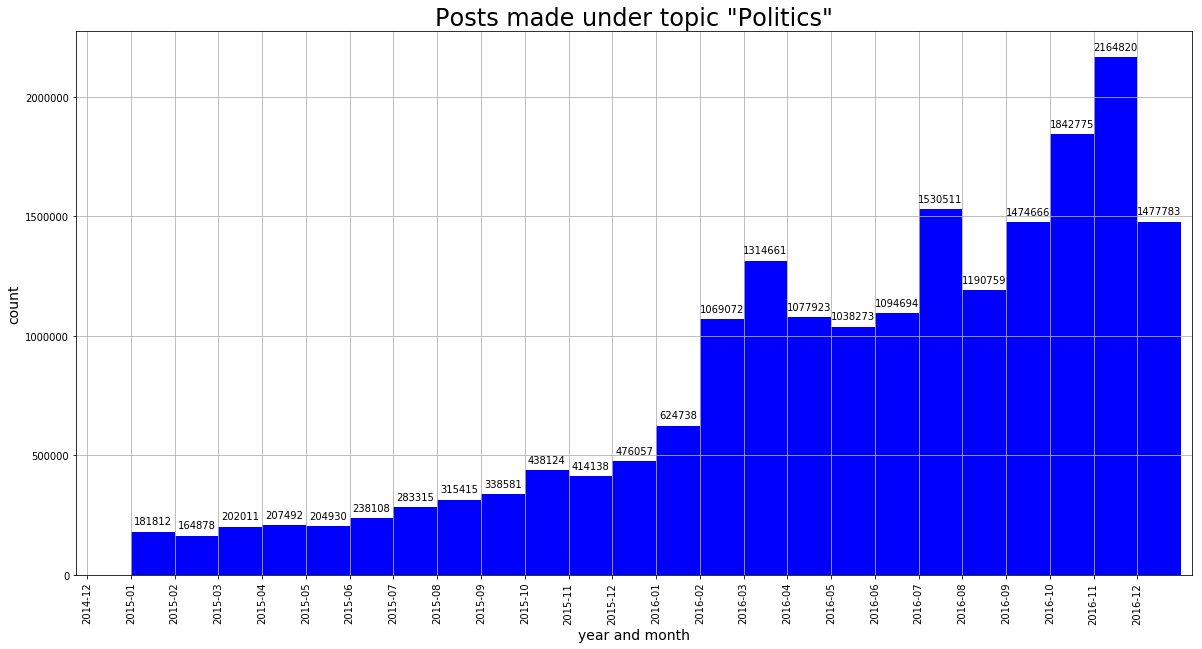

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ax = pdf.plot(kind='bar', y="count", x='year_month', align='edge', width=1.0, figsize=(20,10), color='blue', legend=False)
ax.grid()
plt.title("Posts made under topic \"Politics\"", size=24)
plt.ylabel("count", size=14)
plt.xlabel("year and month", size=14)

for p in ax.patches:
    if p.get_height() > 150000:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

## Word Cloud

Visualize most comment words among users in April 2015/2016 and November 2015/2016. There is a clear trend towards discussion about presidential candidates in 2016. There is also an interesting distincition between the most comment terms used by normal users and those of banned accounts. 

In [108]:
df_2015_04 = nlpdf.where(nlpdf.year == 2015).where(nlpdf.month == 4)
df_2015_11 = nlpdf.where(nlpdf.year == 2015).where(nlpdf.month == 11)
df_2016_04 = nlpdf.where(nlpdf.year == 2016).where(nlpdf.month == 4)
df_2016_11 = nlpdf.where(nlpdf.year == 2016).where(nlpdf.month == 11)
df_bot_word = nlpdf.where(nlpdf.is_bot == True)

In [109]:
from pyspark.sql.functions import array_contains, col, explode

df_2015_04 = df_2015_04.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))
df_2015_11 = df_2015_11.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))
df_2016_04 = df_2016_04.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))
df_2016_11 = df_2016_11.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))
df_bot_word = df_bot_word.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))

In [110]:
word_count_2015_04 = df_2015_04.groupby('body_vec_token_nosw').count()
word_count_2015_11 = df_2015_11.groupby('body_vec_token_nosw').count()
word_count_2016_04 = df_2016_04.groupby('body_vec_token_nosw').count()
word_count_2016_11 = df_2016_11.groupby('body_vec_token_nosw').count()
word_count_bot = df_bot_word.groupby('body_vec_token_nosw').count()

In [111]:
word_count_2015_04_pdf = word_count_2015_04.toPandas()
word_count_2015_11_pdf = word_count_2015_11.toPandas()
word_count_2016_04_pdf = word_count_2016_04.toPandas()
word_count_2016_11_pdf = word_count_2016_11.toPandas()
word_count_bot_pdf = word_count_bot.toPandas()

In [112]:
wordcloud_2015_04 = word_count_2015_04_pdf.sort_values('count', ascending=False)[1:2001]
wordcloud_2015_11 = word_count_2015_11_pdf.sort_values('count', ascending=False)[1:2001]
wordcloud_2016_04 = word_count_2016_04_pdf.sort_values('count', ascending=False)[1:2001]
wordcloud_2016_11 = word_count_2016_11_pdf.sort_values('count', ascending=False)[1:2001]
wordcloud_bot = word_count_bot_pdf.sort_values('count', ascending=False)[1:2001]

In [113]:
# create a dictionary
wordcloud_2015_04 = wordcloud_2015_04.set_index('body_vec_token_nosw').T.to_dict('records')
wordcloud_2015_11 = wordcloud_2015_11.set_index('body_vec_token_nosw').T.to_dict('records')
wordcloud_2016_04 = wordcloud_2016_04.set_index('body_vec_token_nosw').T.to_dict('records')
wordcloud_2016_11 = wordcloud_2016_11.set_index('body_vec_token_nosw').T.to_dict('records')
wordcloud_bot = wordcloud_bot.set_index('body_vec_token_nosw').T.to_dict('records')

In [114]:
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

In [115]:
# instantiate a word cloud object
comments = WordCloud(
    width=1000,
    height=800,
    background_color='white')

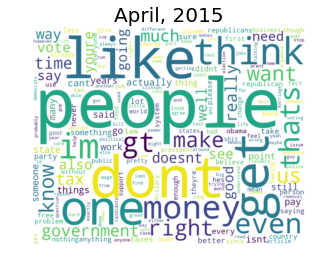

In [116]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2015_04))

import matplotlib.pyplot as plt
%matplotlib inline

# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('April, 2015', fontsize=20)
plt.axis('off')
plt.show()

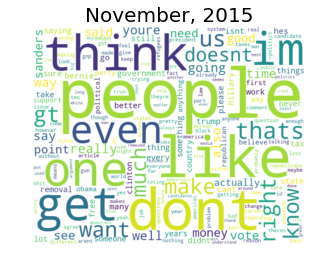

In [117]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2015_11))

# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('November, 2015', fontsize=20)
plt.axis('off')
plt.show()

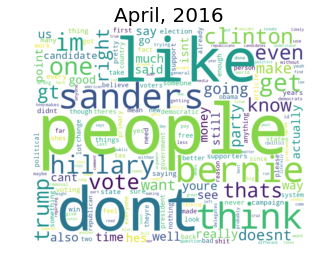

In [118]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2016_04))

# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('April, 2016', fontsize=20)
plt.axis('off')
plt.show()

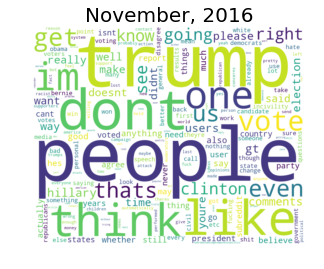

In [119]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2016_11))

# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('November, 2016', fontsize=20)
plt.axis('off')
plt.show()

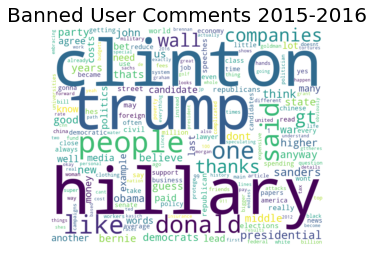

In [120]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_bot))

# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('Banned User Comments 2015-2016', fontsize=20)
plt.axis('off')
plt.show()

## Posts within time interval bins

In [104]:
df_interval_counts = df_raw.where(df_raw.is_bot == False).groupby("time").count()
post_activity = df_interval_counts.sort(asc("time")).toPandas()

Text(0.5,0,'time of day')

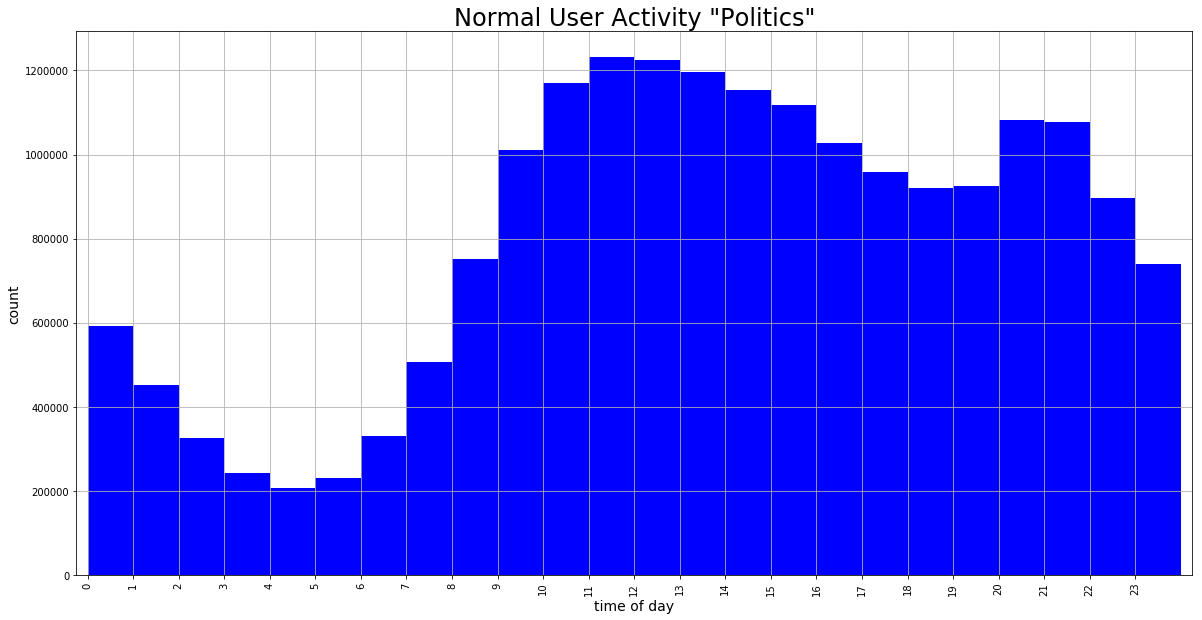

In [106]:
# Plot normal user activity
ax = post_activity.plot(kind='bar', y="count", x='time', align='edge', width=1.0, figsize=(20,10), color='blue', legend=False)
ax.grid()
plt.title("Normal User Activity \"Politics\"", size=24)
plt.ylabel("count", size=14)
plt.xlabel("time of day", size=14)

In [105]:
df_interval_counts_bot = df_raw.where(df_raw.is_bot == True).groupby("time").count()
post_activity_bot = df_interval_counts_bot.sort("time", ascending=True).toPandas()

Text(0.5,0,'time of day')

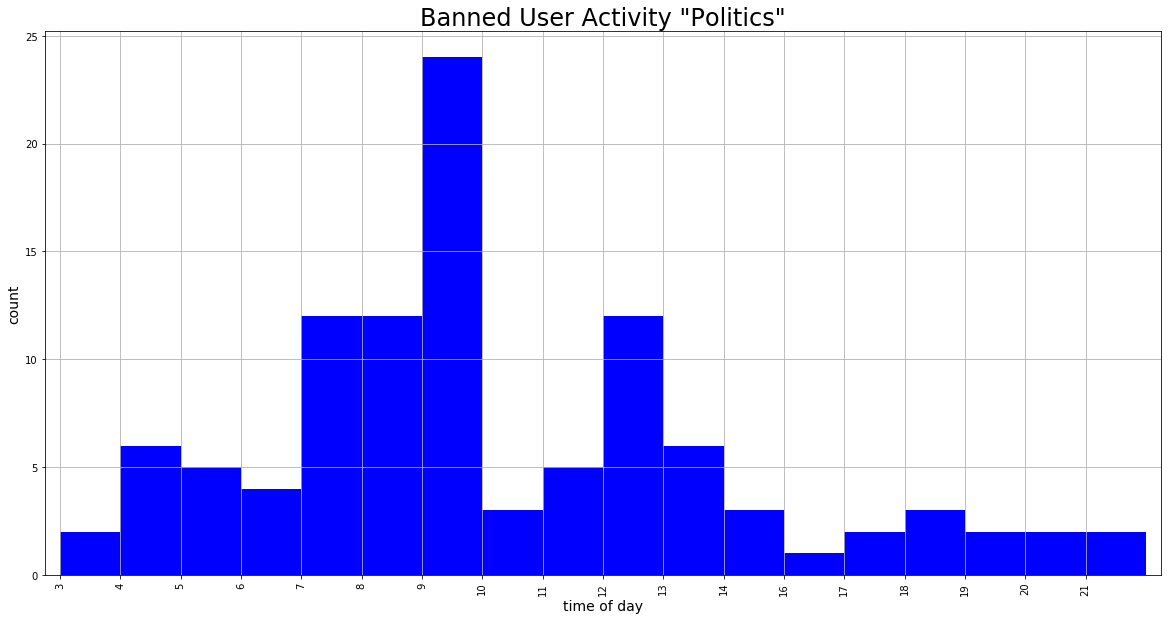

In [107]:
#plot banned user activity
ax = post_activity_bot.plot(kind='bar', y="count", x='time', align='edge', width=1.0, figsize=(20,10), color='blue', legend=False)
ax.grid()
plt.title("Banned User Activity \"Politics\"", size=24)
plt.ylabel("count", size=14)
plt.xlabel("time of day", size=14)

# Modeling <a id="3"></a>

In [34]:
#split data into train and test and ensure label classes are stratified
#train_df_notbanned, test_df_notbanned = nlpdf.filter(nlpdf.label==0).sample(False,0.0001,seed=5).randomSplit([0.8, 0.2])
train_df_notbanned, test_df_notbanned = nlpdf.filter(nlpdf.label==0).randomSplit([0.8, 0.2])
train_df_banned, test_df_banned = nlpdf.filter(nlpdf.label==1).randomSplit([0.8, 0.2])

In [35]:
#unioning training sets and test sets
train_df = train_df_notbanned.union(train_df_banned)
test_df = test_df_notbanned.union(test_df_banned)

## Logistic Regression

In [36]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
start = time.time()
# Set parameters for Logistic Regression
lgr = LogisticRegression(maxIter=10, featuresCol = 'body_vec_tfidf', labelCol='label')

# Fit the model to the data.
lgrm = lgr.fit(train_df)

end = time.time()
print('time to run: {}'.format(end - start))

time to run: 1236.076715707779


In [37]:
start = time.time()
# Given a dataset, predict each point's label, and show the results.
predictions = lgrm.transform(test_df)
predictions = predictions.cache()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print('prediction accuracy: {}'\
          .format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
print('prediction f1 score: {}'\
          .format(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))
end = time.time()
print('time to run: {}'.format(end - start))

prediction accuracy: 0.9999943146181762
prediction f1 score: 0.9999917303610573
time to run: 2519.104952096939


In [38]:
#Turn off Join threshold because it was timing out the multiclassmetrics function
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [69]:
from pyspark.mllib.evaluation import MulticlassMetrics
#confusion matrix
predictionAndLabels=predictions.select(['prediction','label']).rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
cm

array([[3.869551e+06, 1.000000e+00],
       [2.100000e+01, 0.000000e+00]])

In [40]:
#Calculation of precision and recall for banned class
precision = cm[1][1]/(cm[1][1]+cm[0][1])
recall = cm[1][1]/(cm[1][1]+cm[1][0])

print('precision of banned class: {}'.format(precision))
print('recall of banned class: {}'.format(recall))

precision of banned class: 0.0
recall of banned class: 0.0


Based on the business problem we are most interested in boosting recall because these models should be used as a screening method to flag comments for further human review.

In [41]:
#pivot of predictions
predictions.groupby('prediction','label').count().show()

+----------+-----+-------+
|prediction|label|  count|
+----------+-----+-------+
|       0.0|  1.0|     21|
|       1.0|  0.0|      1|
|       0.0|  0.0|3869551|
+----------+-----+-------+



In [42]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

#Extract probability of comment belonging to 1.0 class (a.k.a banned account) 
secondelement=udf(lambda v:float(v[1]),DoubleType())

predictions_prob = predictions.withColumn("probBanned",secondelement('probability'))

Lowering threshold to be labeled as a suspicious account to include 0.01% of top probability comments. Chose 0.01% because if we assume that there are around 1 million comments posted to the politics subreddit every month, this would equate to 100 flagged comments which is a manageable size for the 10 person moderation team.

In [43]:
import numpy as np

#Setting the threshold to include 0.01% of test set in an attempt to increase recall
threshold = np.round(predictions_prob.count() *0.0001,0).astype(int).item()

thresh_prob = predictions_prob.select('probBanned').orderBy('probBanned', ascending=False)\
                .take(threshold)[-1].asDict()["probBanned"]
    
#Relabeling based on lowered threshold
predictions_prob = predictions_prob.withColumn('prob_prediction',when(predictions_prob.probBanned > thresh_prob,1.0)\
                                               .otherwise(0.0))

In [44]:
#Revised confusion matrix
lowerpredictionAndLabels=predictions_prob.select(['prob_prediction','label']).rdd
lowermetrics = MulticlassMetrics(lowerpredictionAndLabels)

lowercm=lowermetrics.confusionMatrix().toArray()
lowercm

array([[3.869166e+06, 3.860000e+02],
       [2.100000e+01, 0.000000e+00]])

In [45]:
#Revised calculation of precision and recall for banned class
lowerprecision = lowercm[1][1]/(lowercm[1][1]+lowercm[0][1])
lowerrecall = lowercm[1][1]/(lowercm[1][1]+lowercm[1][0])

print('precision of banned class: {}'.format(lowerprecision))
print('recall of banned class: {}'.format(lowerprecision))

precision of banned class: 0.0
recall of banned class: 0.0


In [46]:
#revised pivot of predictions with lower threshold
predictions_prob.groupby('prob_prediction','label').count().show()

+---------------+-----+-------+
|prob_prediction|label|  count|
+---------------+-----+-------+
|            0.0|  1.0|     21|
|            1.0|  0.0|    386|
|            0.0|  0.0|3869166|
+---------------+-----+-------+



Logistic regression on user comments does not appear to be a good model for identifying suspicious account activity. This is likely due to the model being trained on uni-grams and not generalizing well on the test set. 

## Random Forest

In [49]:
start = time.time()
from pyspark.ml.classification import RandomForestClassifier
# Set parameters for the Random Forest.
rfc = RandomForestClassifier(maxDepth=20, numTrees=15, impurity="gini", featuresCol='features',
                             labelCol="label")

# Fit the model to the data.
rfcm = rfc.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
rfpredictions = rfcm.transform(test_df)
rfpredictions = rfpredictions.cache()
end = time.time()
print('time to run: {}'.format(end - start))

time to run: 5812.534717559814


In [50]:
print('prediction accuracy: {}'\
          .format(evaluator.evaluate(rfpredictions, {evaluator.metricName: "accuracy"})))
print('prediction f1 score: {}'\
          .format(evaluator.evaluate(rfpredictions, {evaluator.metricName: "f1"})))

prediction accuracy: 0.9999945730446228
prediction f1 score: 0.999991859574297


In [68]:
from pyspark.mllib.evaluation import MulticlassMetrics

rfpredictionAndLabels=rfpredictions.select(['prediction','label']).rdd
metrics = MulticlassMetrics(rfpredictionAndLabels)

rfcm=metrics.confusionMatrix().toArray()
rfcm

array([[3.869552e+06, 0.000000e+00],
       [2.100000e+01, 0.000000e+00]])

In [52]:
rfprecision = cm[1][1]/(cm[1][1]+cm[0][1])
rfrecall = cm[1][1]/(cm[1][1]+cm[1][0])

print('precision of banned class: {}'.format(rfprecision))
print('recall of banned class: {}'.format(rfrecall))

precision of banned class: 0.0
recall of banned class: 0.0


In [53]:
rfpredictions.groupby('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|3869573|
+----------+-------+



In [54]:
rfpredictions_prob = rfpredictions.withColumn("probBanned",secondelement('probability'))

Repeating above step by lowering threshold for classification.

In [62]:
#Setting the threshold to include 0.01% of test set in an attempt to increase recall
rfpredictions_prob = rfpredictions_prob.cache()
rfthreshold = np.round(rfpredictions_prob.count() *0.0001,0).astype(int).item()

In [63]:
#Taking the last element of the probability of prediction
rfthresh_prob = rfpredictions_prob.select('probBanned').orderBy('probBanned', ascending=False)\
                .take(threshold)[-1].asDict()["probBanned"]

In [64]:
#Relabeling based on lowered threshold
rfpredictions_prob = rfpredictions_prob.withColumn('prob_prediction'
                                                   ,when(rfpredictions_prob.probBanned > rfthresh_prob,1.0)\
                                                   .otherwise(0.0))

In [65]:
#Revised confusion matrix
rflowerpredictionAndLabels=rfpredictions_prob.select(['prob_prediction','label']).rdd
rflowermetrics = MulticlassMetrics(rflowerpredictionAndLabels)

rflowercm=rflowermetrics.confusionMatrix().toArray()
rflowercm

array([[3.869293e+06, 2.590000e+02],
       [1.300000e+01, 8.000000e+00]])

In [66]:
#Revised calculation of precision and recall for banned class
rflowerprecision = rflowercm[1][1]/(rflowercm[1][1]+rflowercm[0][1])
rflowerrecall = rflowercm[1][1]/(rflowercm[1][1]+rflowercm[1][0])

print('precision of banned class: {}'.format(rflowerprecision))
print('recall of banned class: {}'.format(rflowerrecall))

precision of banned class: 0.0299625468164794
recall of banned class: 0.38095238095238093


In [67]:
#revised pivot of predictions with lower threshold
rfpredictions_prob.groupby('prob_prediction','label').count().show()

+---------------+-----+-------+
|prob_prediction|label|  count|
+---------------+-----+-------+
|            1.0|  1.0|      8|
|            0.0|  1.0|     13|
|            1.0|  0.0|    259|
|            0.0|  0.0|3869293|
+---------------+-----+-------+



# Results and Future Work

By lowering the threshold for random forest classification we were able to boost recall from 0% to 38%, which is much better than the logistic regression results. 

As an anomaly detection problem, this was quite a difficult problem to tackle. Distinguishing ‘bots’ from far-left or far-right users was difficult with less sophisticated models as the accounts were used by actual people mimicking similar speech patterns.  Having the funds to source stronger processing tools could improve both the amount of data and time of process necessary for this project.

To reduce the data size, we tackled specifically the r/Politics subreddit, whereas many ‘bots’ post across all of Reddit. In future work, accounting for these other subreddits (=significantly larger data) could provide a much stronger dataset for increasing prediction accuracy.